In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data/prices_round_2_day_1.csv', sep=';')

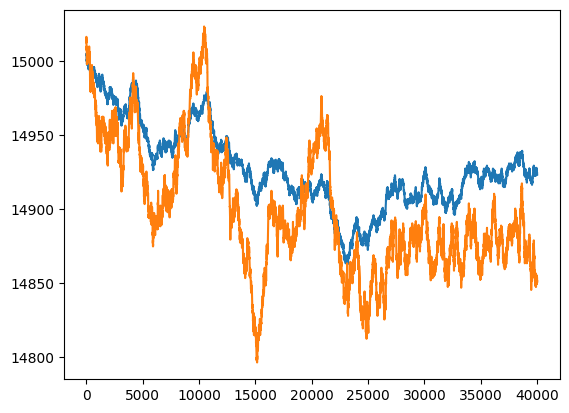

In [5]:
plt.plot(data[data['product'] == 'COCONUTS']['mid_price'] + 7000)
plt.plot(data[data['product'] == 'PINA_COLADAS']['mid_price'])

In [6]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller

coco = data[data['product'] == 'COCONUTS']['mid_price']
pina = data[data['product'] == 'PINA_COLADAS']['mid_price']


model = sm.OLS(coco.to_numpy(), pina.to_numpy()).fit()
model.params[0]

0.5321029098307918

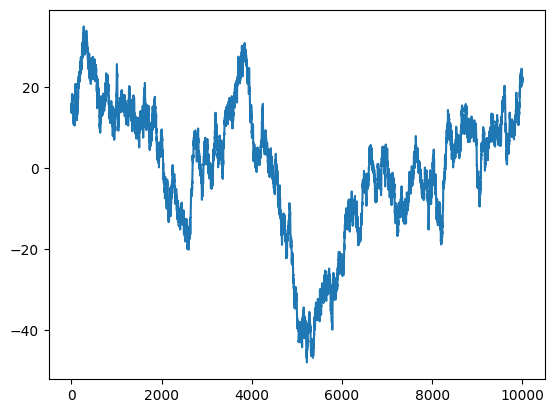

In [7]:
spread = coco.to_numpy() - model.params[0] * pina.to_numpy()
plt.plot(spread)

In [27]:
adf = adfuller(spread, maxlag=1)
print(adf[0])
print(adf[4])

-2.348527682175762
{'1%': -3.431004228818807, '5%': -2.8618291302145686, '10%': -2.566923898875394}
